In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
import numpy as np
import collections

In [2]:
matplotlib.rcParams.update({'font.size': 16})

## Process inputs to create views

In [3]:
# adds the match day number as well as points for a team
def process_match_result(data_row, scores_map):
    if( data_row['FTR']=='D'):
        scores_map[data_row['HomeTeam']] = scores_map.get(data_row['HomeTeam'], list()) + [(data_row['Date'],1)]
        scores_map[data_row['AwayTeam']] = scores_map.get(data_row['AwayTeam'], list()) + [(data_row['Date'],1)]
    elif( data_row['FTR'] == 'A'):
        scores_map[data_row['HomeTeam']] = scores_map.get(data_row['HomeTeam'], list()) + [(data_row['Date'],0)]
        scores_map[data_row['AwayTeam']] = scores_map.get(data_row['AwayTeam'], list()) + [(data_row['Date'],3)]
    elif( data_row['FTR'] == 'H'):
        scores_map[data_row['HomeTeam']] = scores_map.get(data_row['HomeTeam'], list()) + [(data_row['Date'],3)]
        scores_map[data_row['AwayTeam']] = scores_map.get(data_row['AwayTeam'], list()) + [(data_row['Date'],0)]
    
    return scores_map
    
def generate_points_df(inp_data, season_year):
    scores_map = dict()
    
    filtered_match_data = inp_data[ inp_data['SeasonDate'].isin( [season_year] ) ]
    
    for (idx, row) in filtered_match_data.iterrows():
        scores_map = process_match_result(row, scores_map)
        
    # process the (date, points earned) into (matchday, cumulative points earned)
    points_table = list()
    for (team, points_list) in scores_map.items():
        points_list.sort(key=lambda x: x[0])
        cumulative_points = np.cumsum([x[1] for x in points_list]).tolist()
        temp = [ {'team': team, 'matchday': v+1, 'points': cumulative_points[v]} for v in range(len(cumulative_points)) ]
        points_table.extend(temp)
    
    return pd.DataFrame(points_table)

    
def get_competitiveness_from_points_df(points_df, points_threshold):
    matchdays = points_df[ 'matchday'].unique()
    
    for matchday in matchdays:
        sub_df = points_df.loc[points_df['matchday'] == matchday, :]
        points_count = sub_df['points'].tolist()
        points_list = points_count
    
        comp_map = dict()
        for point in points_list:
            #comp_map[point] = (np.sum(np.exp2(np.array([-abs(x-point)/2 for x in points_list]))) - 1)/20.0
            comp_map[point] = (len([1 for x in points_list if abs(x-point) < 3])-1)/5.0
            
        points_df.loc[points_df['matchday'] == matchday, 'is_competitive'] = sub_df.apply( lambda row: comp_map.get(row['points'], 0) , axis=1 )
        
        
    
def get_ranking_from_points_list(points_with_counts):
    points_list = sorted(points_with_counts.keys(), reverse=True)
    
    points_to_rank = dict()
    curr_rank = 1
    for point in points_list:
        points_to_rank[point] = curr_rank
        curr_rank += points_with_counts[point]
    
    return points_to_rank

def add_ranking_to_points_df(points_df):
    matchdays = points_df[ 'matchday'].unique()
    
    # fetch all the points for a given matchday
    for matchday in matchdays:
        matchday_df = points_df.loc[points_df['matchday'] == matchday, :]
        rank_map = get_ranking_from_points_list( matchday_df['points'].value_counts())
        points_df.loc[points_df['matchday'] == matchday, 'rank'] = matchday_df.apply( lambda row: rank_map[row['points']], axis=1)  

def get_ranking_array(inp_data, season_year):
    points_array = get_points_array(inp_data, season_year)
    
    num_matches = len(next(iter(points_array.values())))
    
    ranking_table = list()
    for matchday in range(num_matches):
        temp_dict = dict()
        for team, points_list in points_array.items():
            temp_dict[team] = points_list[matchday]
        
        ranking_table.append(get_ranking_from_points(temp_dict))
    
    return ranking_table

def get_ranking_progression_by_team(inp_data, season_year):
    ranking_progression_by_team = dict()
    ranking_array = get_ranking_array(inp_data, season_year)
    
    for rank in ranking_array:
        for team, rank in rank.items():
            ranking_progression_by_team[team] = ranking_progression_by_team.get(team, list()) + [rank]

    return ranking_progression_by_team

def get_diff_metric_in_rankings(old_ranking, new_ranking):
    team_names = old_ranking.keys()
    
    switch_value = 0
    
    for team in team_names:
        switch_value += abs(new_ranking[team] - old_ranking[team])
        #switch_value += max(new_ranking[team] - old_ranking[team], 0)
        #if(new_ranking[team] > old_ranking[team]):
        #    switch_value +=1
        
    return switch_value
        
def get_diff_metric_array(ranking_table):
    metric_array = list()
    for idx in range(len(ranking_table)-1):
        metric_array.append(get_diff_metric_in_rankings(ranking_table[idx], ranking_table[idx+1]))

    return(metric_array)


def get_points_endseason(inp_data, season_year):
    full_table = get_points_array(inp_data, season_year)
    
    final_points = dict()
    for(team, points_list) in full_table.items():
        final_points[team] = points_list[-1]
        
    return final_points
    

In [4]:
#top level function to generate competetiveness analysis
def generate_competetiveness_map(league_name, comp_threshold, plot = False):
    raw_input = pd.read_csv('data/' + league_name + '/concat.csv', keep_default_na=True)
    
    season_years = raw_input['SeasonDate'].unique()
    
    avg_vals_list = []
    
    for year, subdf in raw_input.groupby(['SeasonDate']):
        if year>=2018:
            continue
        
        points_df = generate_points_df(subdf, year)
        add_ranking_to_points_df(points_df)
        get_competitiveness_from_points_df(points_df, comp_threshold)
        
        sub_vals = points_df[['matchday', 'rank', 'is_competitive']]
        img = sub_vals.pivot_table(index="rank", columns="matchday", values="is_competitive").fillna(method="ffill")
        avg_vals_list.append(img)
        
        if plot: 
            fig = plt.figure(figsize=(15,5))
            im = plt.imshow(img, cmap="coolwarm", vmin=0, vmax=1)
            plt.xlabel('Matchday')
            plt.ylabel('Rank')
            fig.colorbar(im)
            plt.title('Competitiveness map [metric = ' + str(np.average(img.iloc[:,10:])) + ']')
            plt.savefig('result/' + league_name + '/competetiveness/map_' + str(year) + '.png')

    temp = np.stack(avg_vals_list,axis=2)
    avg_vals = np.median(temp,axis=2)
    
    if plot: 
        fig = plt.figure(figsize=(15,5))
        im = plt.imshow(avg_vals, cmap="coolwarm", vmin=0, vmax=1)
        plt.xlabel('Matchday')
        plt.ylabel('Rank')
        fig.colorbar(im)
        plt.title('Competitiveness map')
        plt.savefig('result/' + league_name + '/competetiveness/map_avg.png')
    
    avg_metric = np.average(avg_vals[:,10:]) 
    return avg_metric

        

In [16]:
#top level function to generate ranking matrix
def generate_rank_matrix(league_name, plot = False):
    raw_input = pd.read_csv('data/rankings.csv', keep_default_na=True)
    
    league_input = raw_input.loc[raw_input['league']==league_name, :]
    
    prev_ranks = None
    
    ranking_mat = np.zeros((17,20))
    
    for year, subdf in league_input.groupby(['SeasonDate']):
        if year < 2008:
            continue
        
        final_ranks = subdf.loc[:, ['team', 'rank']]
        
        if prev_ranks is not None:
            # figure out the new ranks
            merged_df = pd.merge(prev_ranks, final_ranks, how='inner', on='team')
            if(len(merged_df.index) < 17):
                print(year)
            
            for idx, row in merged_df.iterrows():
                try:
                    ranking_mat[int(row['rank_x'])-1, int(row['rank_y'])-1] += 1
                except Exception as e: 
                    print(e)
                    print('in adding')
                    print(row)
                    
            
        prev_ranks = final_ranks
        
    if plot: 
        fig = plt.figure(figsize=(10,8))
        im = plt.imshow(ranking_mat, interpolation=None, cmap=plt.cm.Blues, vmin=0, vmax=7, origin='lower')
        plt.xlabel('Next year rank')
        plt.ylabel('Current rank')
        plt.grid(True)
        plt.xticks([])
        plt.yticks([])
        plt.plot(plt.xlim(), (3.5,3.5), color='c', ls="--", c=".3")
        plt.plot((3.5,3.5), plt.ylim(), color='c', ls="--", c=".3")
        plt.plot((16.5,16.5), plt.ylim(), color='m', ls="--", c=".3")
        plt.plot(plt.ylim(), plt.ylim(), ls="--", c=".3", color='k')
        fig.colorbar(im)
        plt.title('Ranking matrix - ' + league_name )
        plt.savefig('result/' + league_name + '/ranking/rank.png')
            
        

index 17 is out of bounds for axis 0 with size 17
in adding
team      Eibar
rank_x       18
rank_y       14
Name: 16, dtype: object


/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:2400: UserWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'
  seen=seen, canon=canonical, used=seen[-1]))


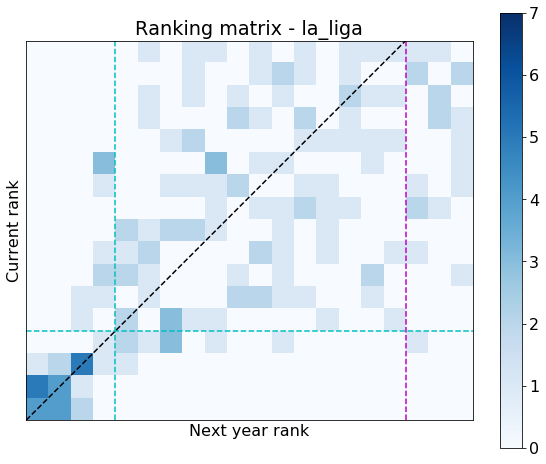

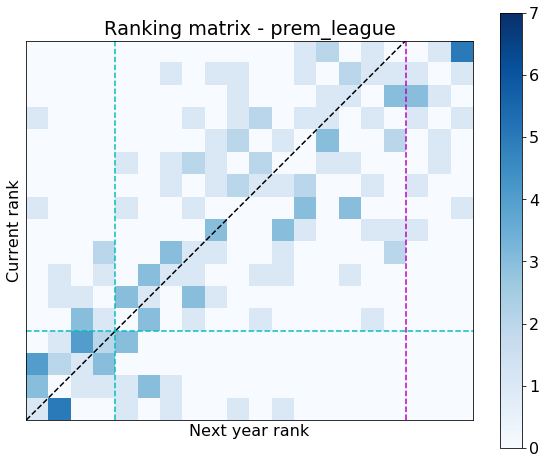

In [17]:
generate_rank_matrix('la_liga', plot = True)
generate_rank_matrix('prem_league', plot = True)

/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


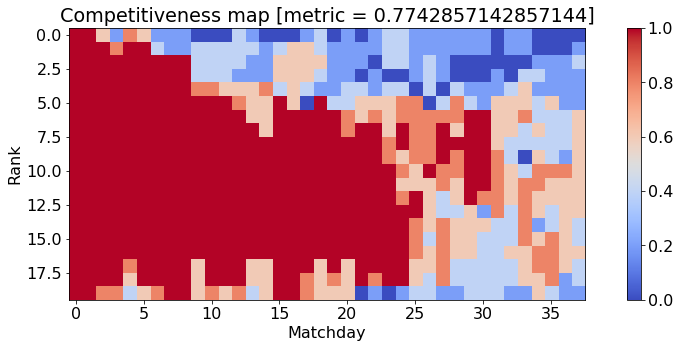

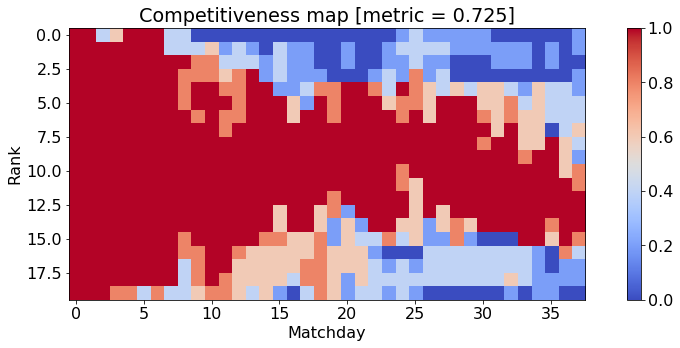

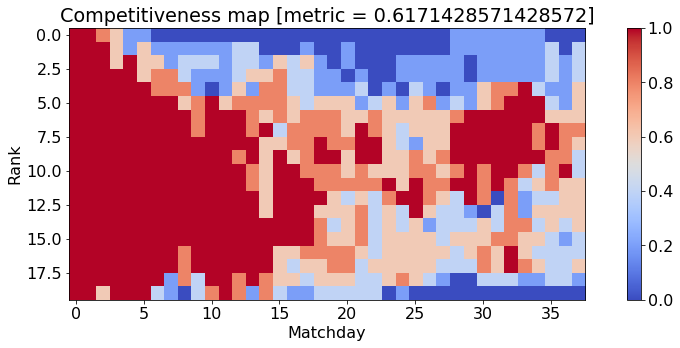

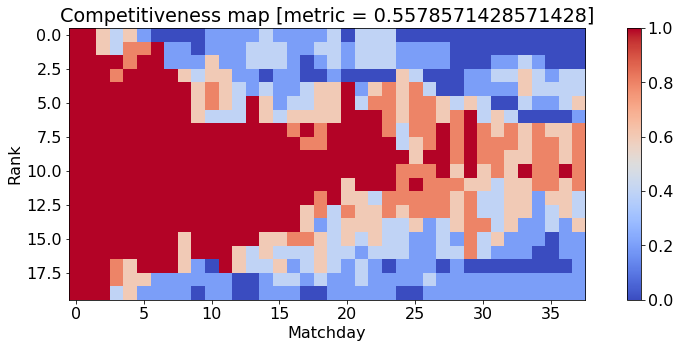

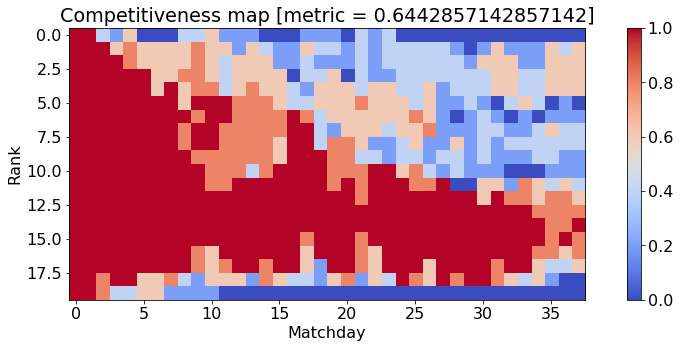

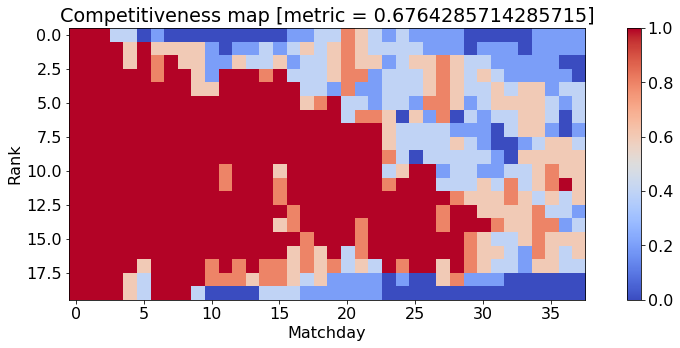

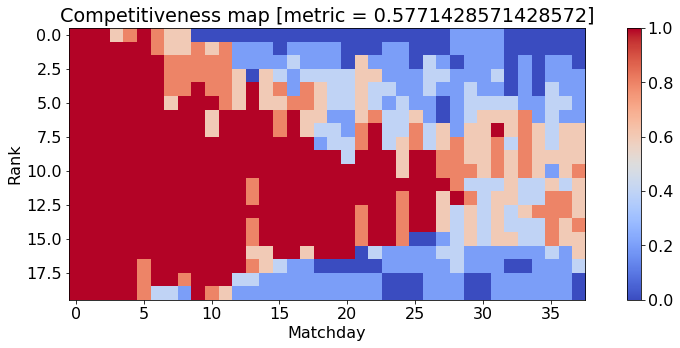

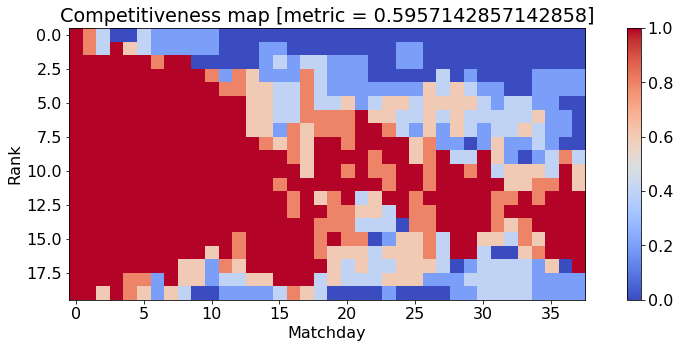

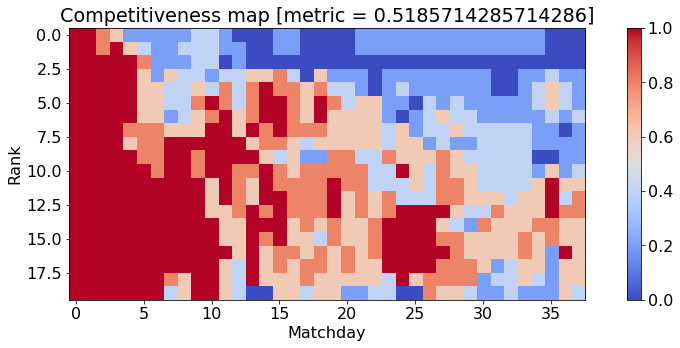

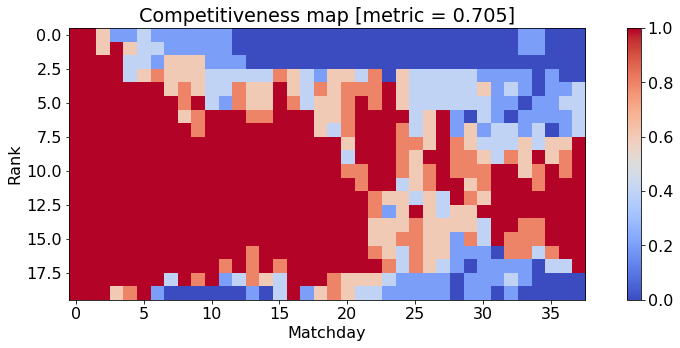

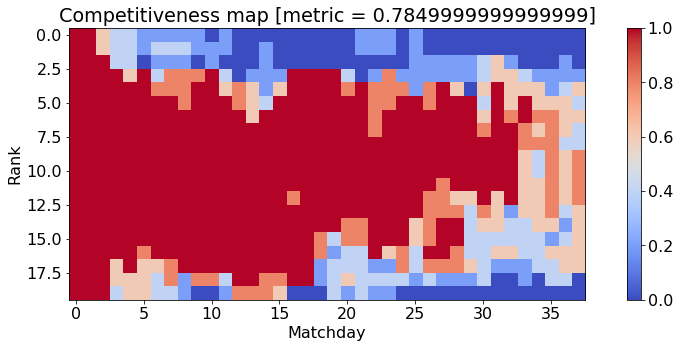

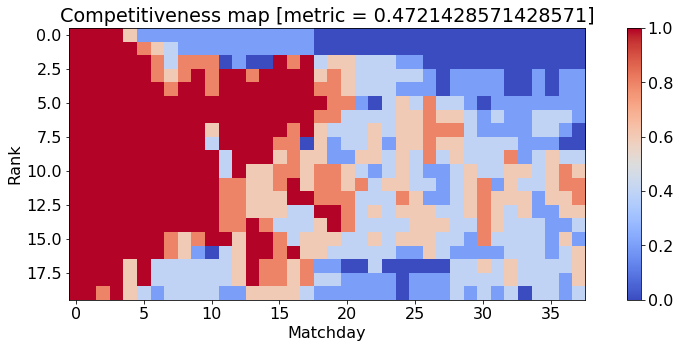

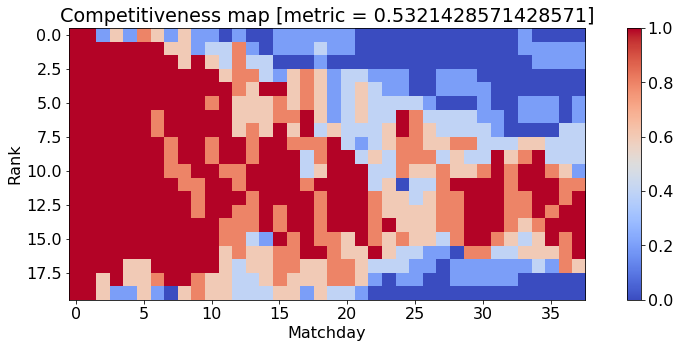

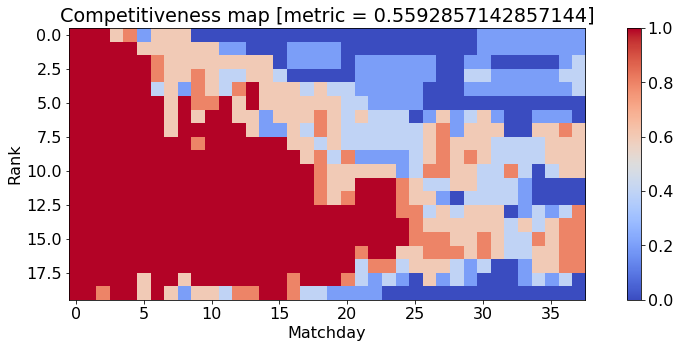

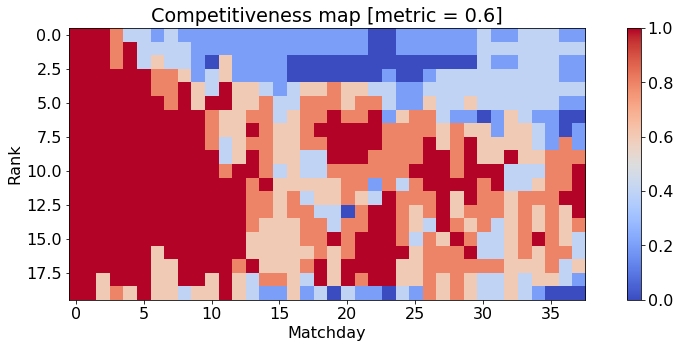

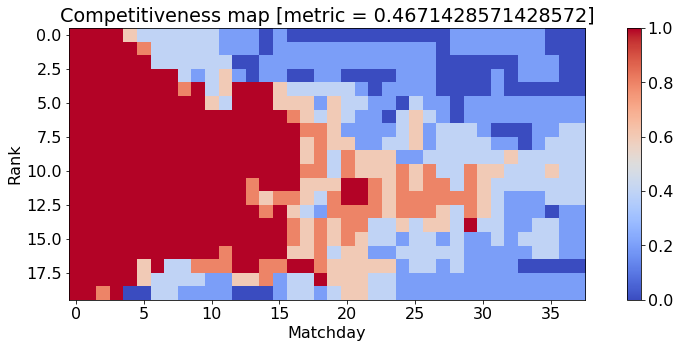

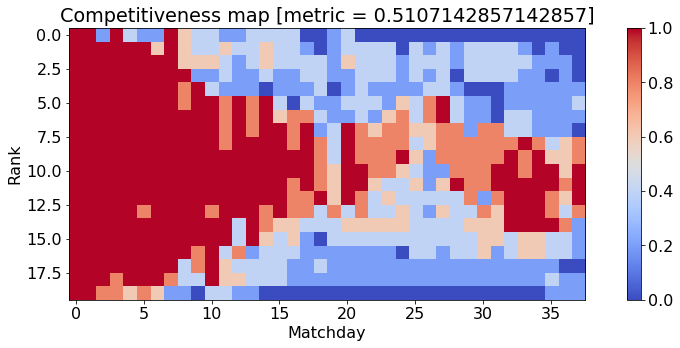

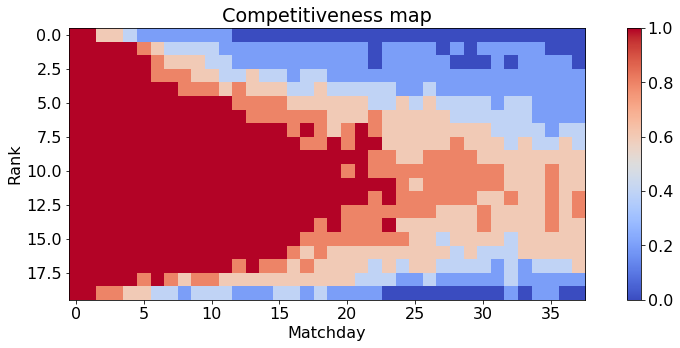

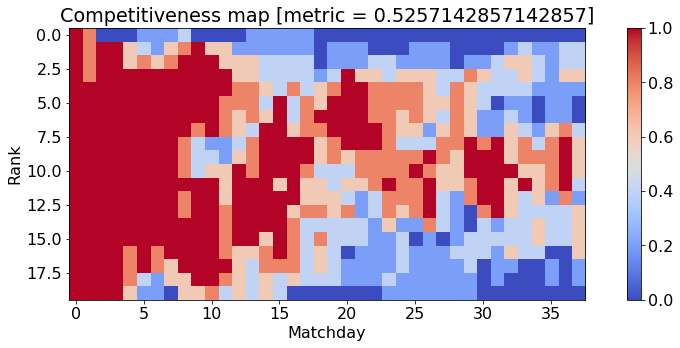

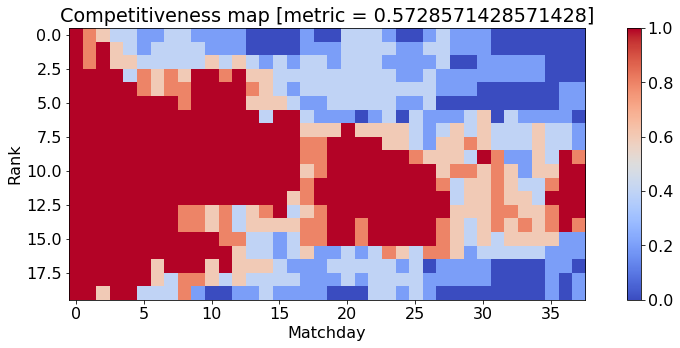

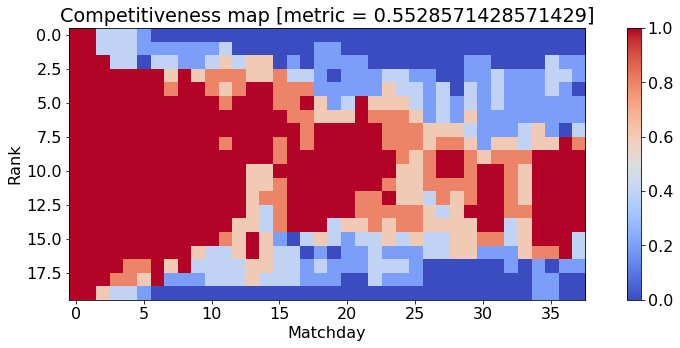

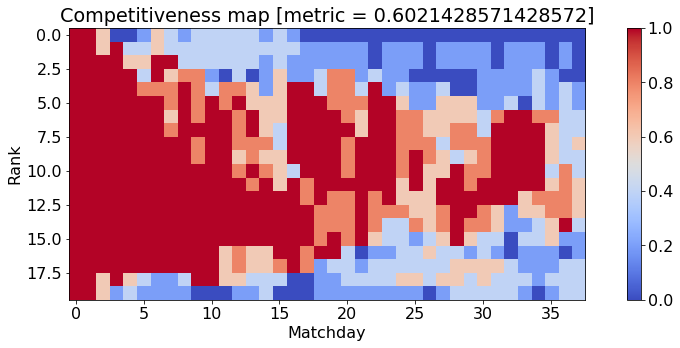

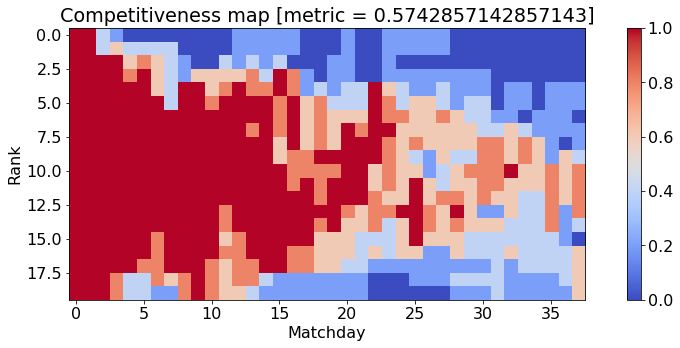

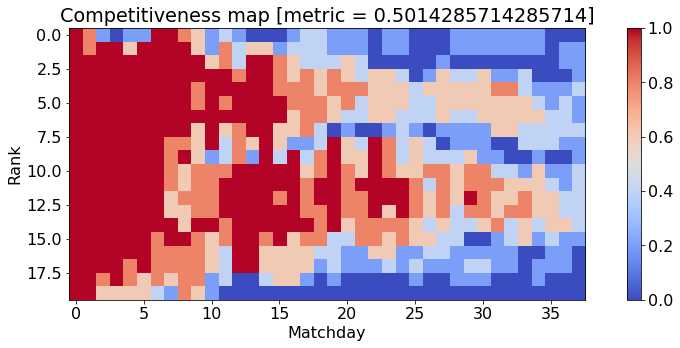

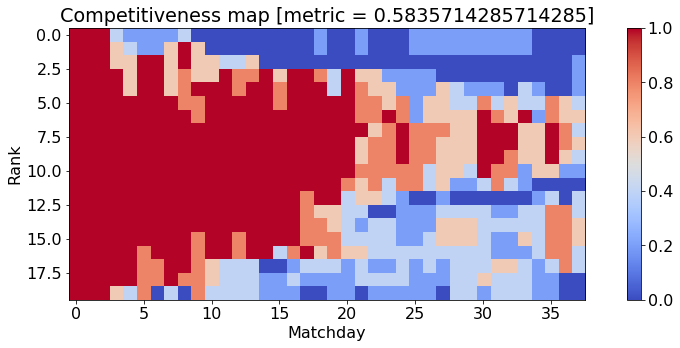

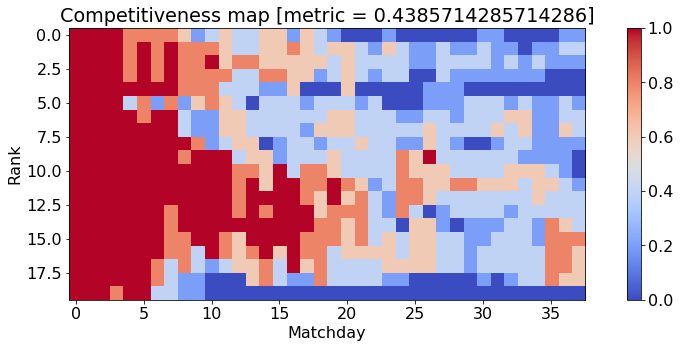

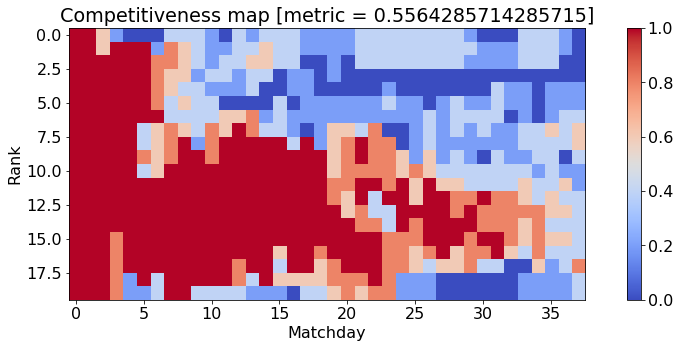

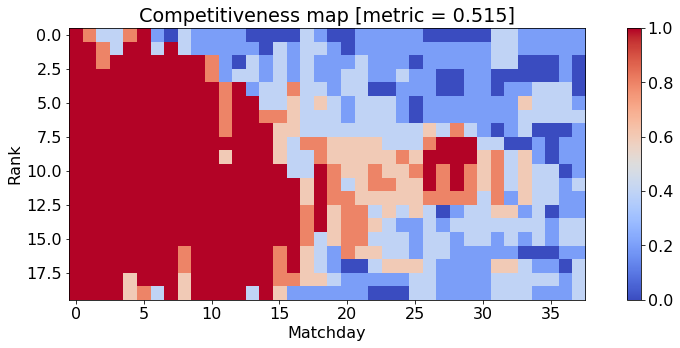

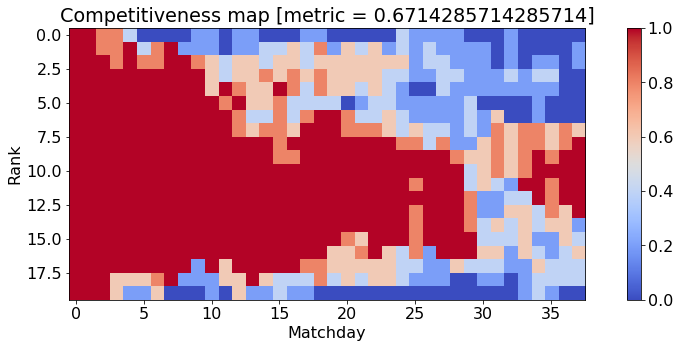

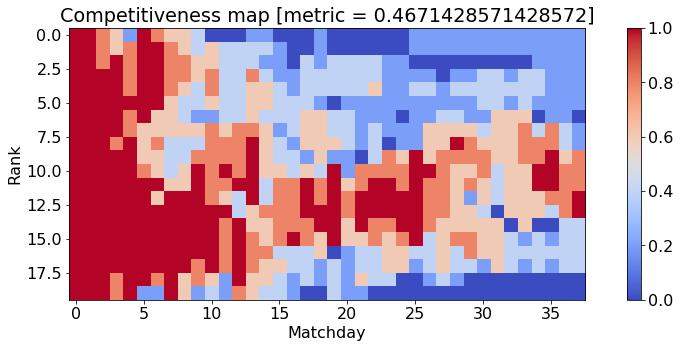

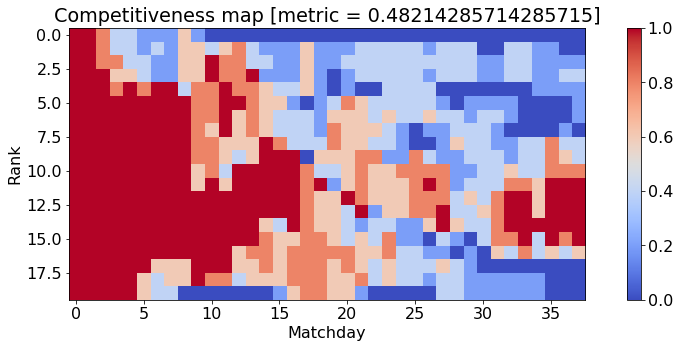

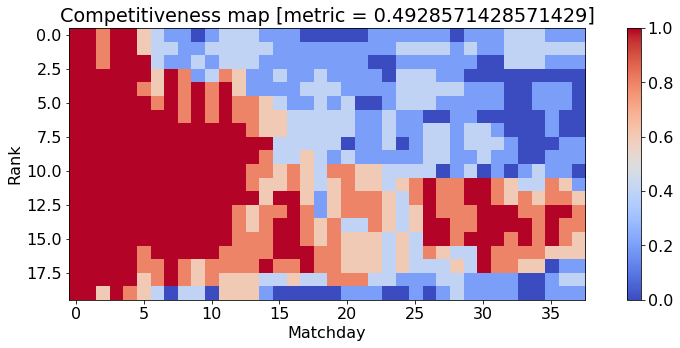

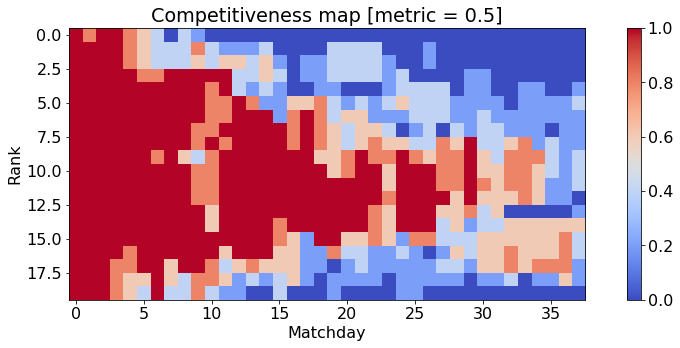

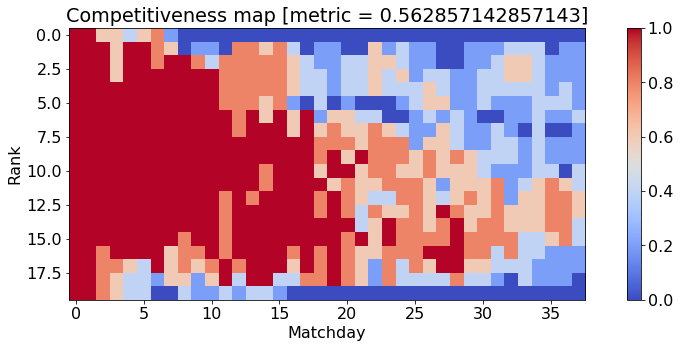

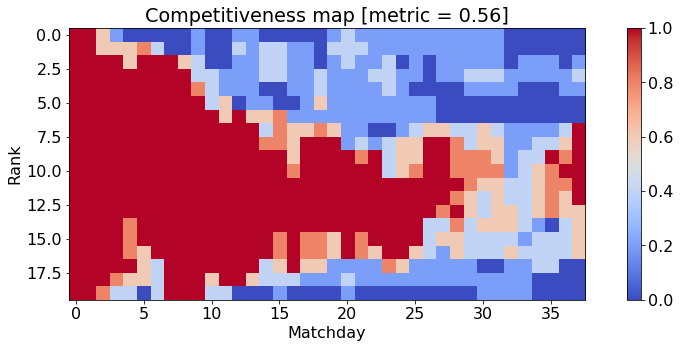

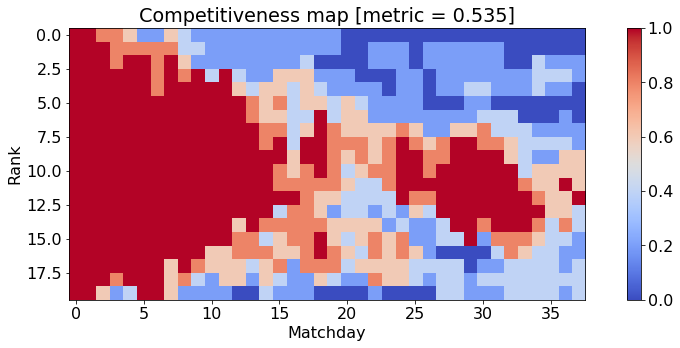

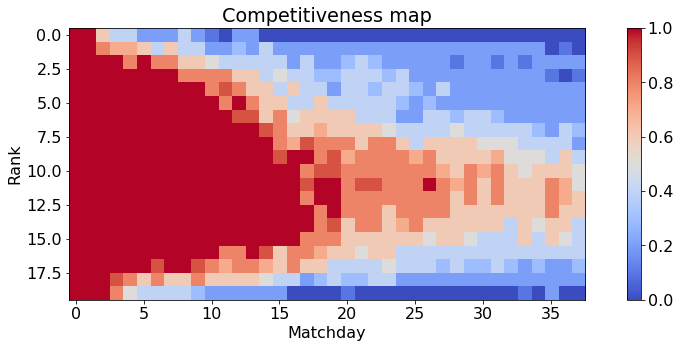

In [7]:
comp_metric_esp = generate_competetiveness_map('la_liga', 3, plot = True)
comp_metric_eng = generate_competetiveness_map('prem_league', 3, plot = True)

In [8]:
print(comp_metric_esp)
print(comp_metric_eng)

0.5767857142857142
0.5166071428571429


NameError: name 'points_df_2015' is not defined

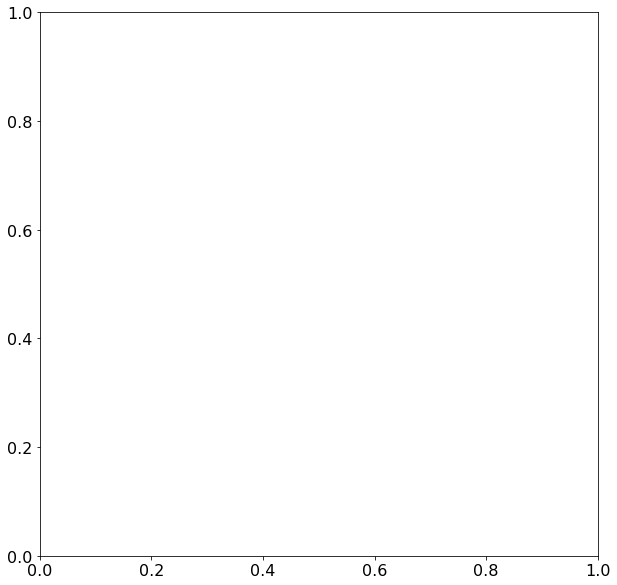

In [9]:
fig = plt.figure(figsize=(10,10))
#ax = fig.get_axes()
ax = fig.subplots()
for team, subdf in points_df_2015.groupby(['team']):
    ax = subdf.plot(x='matchday', y='rank', ax=ax, marker='*', label=team)
plt.legend(loc = 'best')
plt.show()

In [ ]:
team_cut = points_df_2015.loc[points_df_2015['team'] == 'Leicester', ['matchday', 'rank']]
team_cut.plot(x='matchday', y='rank', marker='*', title='Chelsea points chart 2015')

In [ ]:
%matplotlib inline
plt.style.use('seaborn-dark-palette')
diff_metric_sum = dict()
plt.figure(figsize=(10,10))
for yr in range(2005,2018):
    ranking_table = get_ranking_array(raw_input, yr)
    diff_metric = get_diff_metric_array(ranking_table)
    diff_metric_sum[yr] = np.sum(diff_metric[5:])
    plt.plot(diff_metric[5:], color=cm.tab20b((yr-2005.0)/13), label=str(yr))
#     
plt.title('League diff metric')
plt.legend()
# plt.colormap
plt.savefig('result/diff_metric.png')

plt.figure(figsize=(10,10))
plt.plot(diff_metric_sum.keys(), diff_metric_sum.values(), marker='.')
plt.title('Season diff metric')
plt.savefig('result/diff_metric_sum.png')
    #plt.show()

In [ ]:
# print(diff_metric_sum)

In [ ]:
%matplotlib inline
for yr in range(2005,2018):
    pts_table = get_ranking_progression_by_team(raw_input, yr)
    plt.figure(figsize=(10,10))
    for team, pt_list in pts_table.items():
        plt.plot(pt_list, label=team)
    plt.title('League ranking progression ' + str(yr))
    plt.legend()
    plt.savefig('result/league_ranking_' + str(yr) + '.png')
    #plt.show()

In [ ]:
%matplotlib inline
for yr in range(2001,2018):
    pts_table = get_points_array(raw_input, yr)
    plt.figure(figsize=(10,10))
    for (team, pt_list) in pts_table.items():
        plt.plot(pt_list, label=team)
    plt.title('League points table ' + str(yr))
    plt.legend()
    plt.savefig('result/league_points_' + str(yr) + '.png')
    #plt.show()

In [ ]:
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 2, 1, projection='3d')
xvals = list()
yvals = list()
zvals = list()
for yr in range(2005,2018):
    pts_list = sorted(get_points_endseason(raw_input, yr).values())
    xvals += range(20)
    yvals += [yr]*20
    zvals += (pts_list)
print(len(xvals))
print(len(yvals))
print(len(zvals))
surf = ax.plot_surface(np.array(xvals), np.array(yvals), np.array(zvals), cmap=cm.coolwarm, antialiased=False)
#plt.plot(pts_list, label=yr, color=cm.inferno((yr-2000.0)/20))
plt.title('Season end points')
plt.legend()
plt.savefig('result/final_standings_curve.png')

In [ ]:
print(raw_input['SeasonDate'])
#get_season(raw_input['Date'][0])

In [ ]:
raw_input.columns

In [ ]:
raw_input.head()

In [ ]:
winners = pd.DataFrame(columns=["team", "date", "points"])


winners = raw_input.loc[raw_input["FTR"]=="H", ][""]

In [ ]:
raw_input['SeasonDate'].value_counts()